In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
file = open("data_risk2_dummy","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [3]:
X_train.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [4]:
X_test.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [5]:
y_train.value_counts()

0    109536
1      4293
Name: cancer, dtype: int64

# Stacking Ensemble Model on Cancer Data

### Default Hyperparameters

We have already tuned the hyperparameters of various models to be used for the ensemble - 

In [6]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi = TP / float(TP+FN)
    speci = TN / float(TN+FP)
    
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)

    print("Average:", (sensi+speci)/2)

    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

In [7]:
# Importing random forest classifier from sklearn library
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from numpy import mean
from sklearn.pipeline import make_pipeline

In [8]:
# code has been written with the help of https://machinelearningmastery.com/voting-ensembles-with-python/
from sklearn.calibration import CalibratedClassifierCV

def get_stacking(pt):
    folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 100)
    level0 = []
     
    level0.append(('XGB', XGBClassifier(learning_rate =0.1, n_estimators=300, max_depth=5, min_child_weight=6, gamma=0,
                                        subsample=0.9, colsample_bytree=0.9, objective= 'binary:logistic', nthread=4,
                                        reg_alpha=0, scale_pos_weight=25, seed=27)))
    level0.append(('LR', LogisticRegression(C=0.1, class_weight='balanced')))
    #level0.append(('SGD', make_pipeline(SGDClassifier(class_weight = 'balanced', loss = 'hinge', penalty = 'l1',
    #                                                  random_state = 100), CalibratedClassifierCV(cv='prefit'))))
    level0.append(('RF', RandomForestClassifier(random_state = 100, n_estimators=500 ,max_depth=6 ,min_samples_leaf=100,
                                                min_samples_split=200, max_samples=0.8, criterion='entropy', 
                                                class_weight='balanced')))
   
    level1 = LogisticRegression(class_weight='balanced')
    
    ensemble = StackingClassifier(estimators=level0, final_estimator=level1, cv=folds, passthrough=pt)
    return ensemble

def get_models():
    models = dict()
    '''models['XGB'] = XGBClassifier(learning_rate =0.1, n_estimators=50, max_depth=5, min_child_weight=1, gamma=0,
                                  subsample=0.9, colsample_bytree=0.6, objective= 'binary:logistic', nthread=4,
                                  reg_alpha=0.05, scale_pos_weight=130, seed=27)
    models['LR'] = LogisticRegression(C=10, class_weight='balanced')
    #models['SGD'] = make_pipeline(SGDClassifier(class_weight = 'balanced', loss = 'hinge', penalty = 'l1',
    #                                                  random_state = 100), CalibratedClassifierCV(cv='prefit'))
    models['RF'] = RandomForestClassifier(random_state = 100, n_estimators=50 ,max_depth=8 ,min_samples_leaf=200, 
                                          min_samples_split=200,max_samples=0.8, class_weight='balanced')
    '''
    #passthrough = False means only the predictions of the estimators would be used as training data
    models['ensemble1'] = get_stacking(False)
    #passthrough = True means along with the predictions of the estimators, the original data also
    #would be used as training data
    models['ensemble2'] = get_stacking(True)
    return models

def evaluate_model(model, X, y):
    # Create a cross validation scheme
    folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 100)
    scores = cross_val_score(model, X, y, scoring='balanced_accuracy',cv = folds, n_jobs = -1,verbose = 1)
    return scores

In [9]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(name,"->", mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ensemble1 -> 0.7274804816327238
ensemble2 -> 0.7275874984158153


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.5min finished


In [10]:
# fit
models['ensemble2'].fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
                   estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9, gamma=0,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.1,
                                              max_delta_step=None, max_depth=5,
                                              min_child_weight=6, m...
                                              validate_parameters=None,
                                              verbosity=None)),
                            

In [11]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train = models['ensemble2'].predict(X_train) # For train data
#y_pred_train=(models['ensemble2'].predict_proba(X_train)[:,1] > 0.46).astype(bool)

#### Evaluating ensemble model on train data

Confusion Matrix ->
[[79164 30372]
 [  583  3710]]
Accuracy: 0.7280569977773678
Sensitivity: 0.8641975308641975
Specificity: 0.7227212971078002
Average: 0.7934594139859988
Precision 0.10885511413649433
MCC  0.2441277853549405
F1  0.19335504885993487
F2  0.36192297186561045
F3  0.5101830333200401
ROC-AUC : 0.87


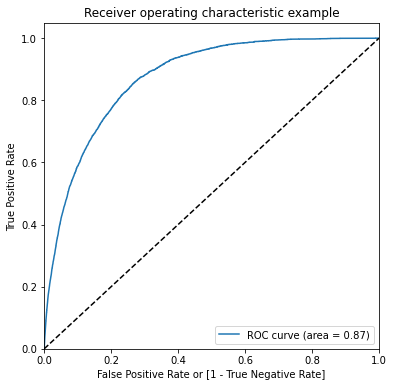

In [12]:
# For train
model_stats(X_train, y_train, y_pred_train, models['ensemble2'])

#### #### Evaluating ensemble model on test data

Confusion Matrix ->
[[36139 21791]
 [  381  1190]]
Accuracy: 0.6273676072671047
Sensitivity: 0.7574793125397836
Specificity: 0.6238391161746936
Average: 0.6906592143572385
Precision 0.05178190679256777
MCC  0.12556766134434078
F1  0.09693711306614532
F2  0.20331453955236628
F3  0.3205818965517241
ROC-AUC : 0.77


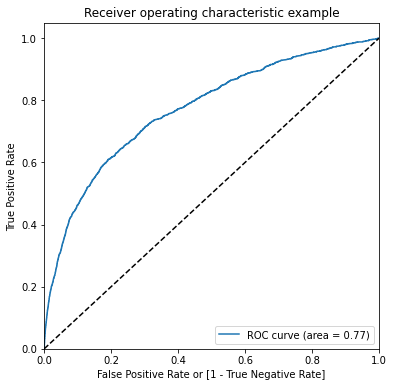

In [13]:
# For test
y_pred_test = models['ensemble2'].predict(X_test) # For test data
#y_pred_test=(models['ensemble2'].predict_proba(X_test)[:,1] > 0.46).astype(bool)
model_stats(X_test, y_test, y_pred_test, models['ensemble2'])

In [14]:
# fit
models['ensemble1'].fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
                   estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9, gamma=0,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.1,
                                              max_delta_step=None, max_depth=5,
                                              min_child_weight=6, m...
                                              subsample=0.9, tree_method=None,
                                              validate_parameters=None,
             

In [15]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train = models['ensemble1'].predict(X_train) # For train data
#y_pred_train=(models['ensemble1'].predict_proba(X_train)[:,1] > 0.47).astype(bool)

#### Evaluating ensemble model on train data

Confusion Matrix ->
[[79562 29974]
 [  645  3648]]
Accuracy: 0.7310087938925933
Sensitivity: 0.8497554157931516
Specificity: 0.7263548057259713
Average: 0.7880551107595615
Precision 0.10850038665159717
MCC  0.2405728179973337
F1  0.19243043650270342
F2  0.359097531204473
F3  0.5048506068448222
ROC-AUC : 0.87


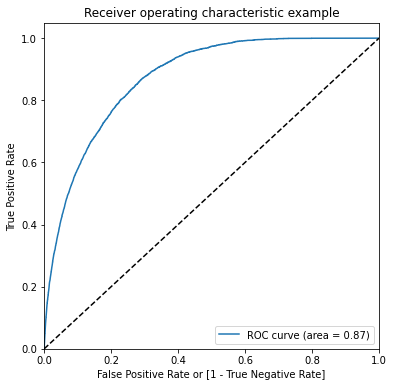

In [16]:
# For train
model_stats(X_train, y_train, y_pred_train, models['ensemble1'])

#### #### Evaluating ensemble model on test data

Confusion Matrix ->
[[36251 21679]
 [  381  1190]]
Accuracy: 0.6292499285726291
Sensitivity: 0.7574793125397836
Specificity: 0.625772484032453
Average: 0.6916258982861183
Precision 0.05203550658096113
MCC  0.12631942893374534
F1  0.09738134206219314
F2  0.20409563338249925
F3  0.32155209684392566
ROC-AUC : 0.77


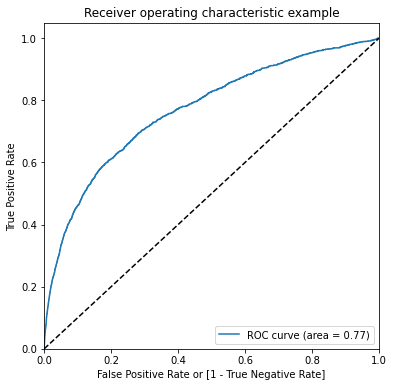

In [17]:
# For test
y_pred_test = models['ensemble1'].predict(X_test) # For test data
#y_pred_test=(models['ensemble1'].predict_proba(X_test)[:,1] > 0.47).astype(bool)
model_stats(X_test, y_test, y_pred_test, models['ensemble1'])